Found 16418 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.
Epoch 1/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 460s 885ms/step - accuracy: 0.0384 - loss: 4.7270 - val_accuracy: 0.4046 - val_loss: 3.2181 - learning_rate: 1.0000e-04
Epoch 2/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 455s 885ms/step - accuracy: 0.2317 - loss: 3.3833 - val_accuracy: 0.6115 - val_loss: 1.9467 - learning_rate: 1.0000e-04
Epoch 3/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 463s 900ms/step - accuracy: 0.3539 - loss: 2.5870 - val_accuracy: 0.6718 - val_loss: 1.4735 - learning_rate: 1.0000e-04
Epoch 4/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 462s 898ms/step - accuracy: 0.4273 - loss: 2.2039 - val_accuracy: 0.7018 - val_loss: 1.2557 - learning_rate: 1.0000e-04
Epoch 5/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 471s 916ms/step - accuracy: 0.4581 - loss: 2.0438 - val_accuracy: 0.7119 - val_loss: 1.1384 - learning_rate: 1.0000e-04
Epoch 6/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 463s 900ms/step - accuracy: 0.4810 - loss: 1.9497 - val_accuracy: 0.719

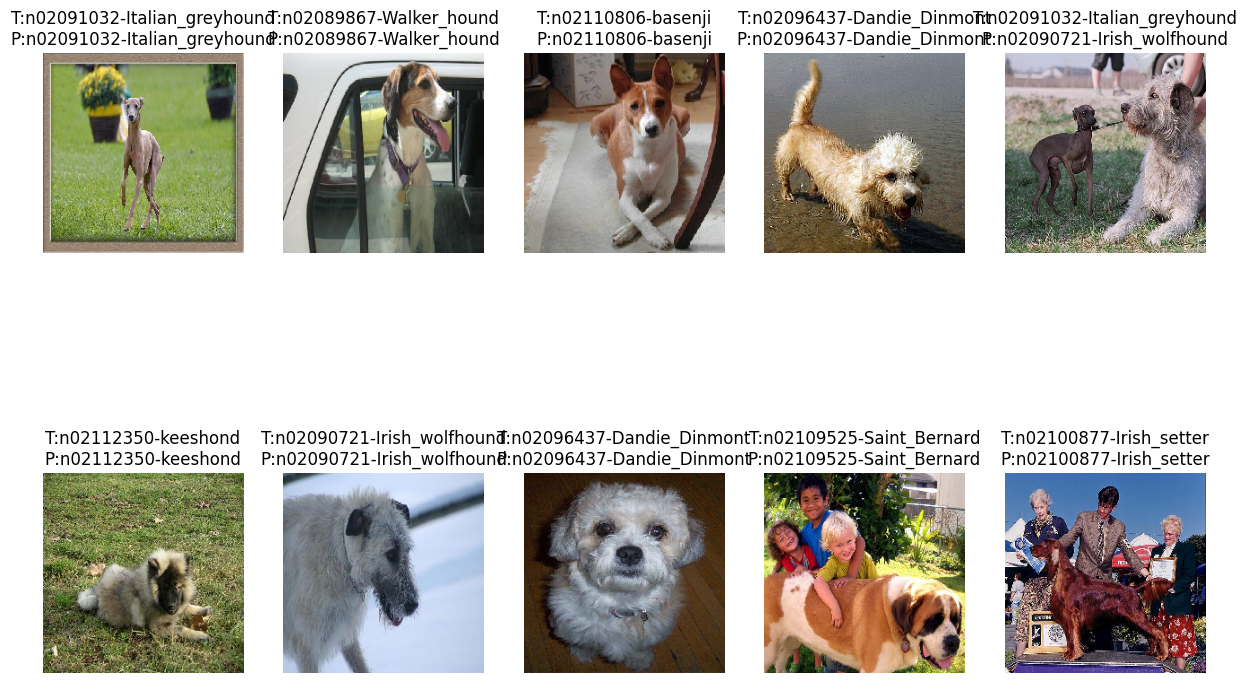

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Veri yolu
train_data_dir = 'C:/Users/Barış/Desktop/SinirAgları2/train'
validation_data_dir = 'C:/Users/Barış/Desktop/SinirAgları2/validation'

# Veri artırma (veri genişletme)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.7, 1.3]
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Veri yükleme
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# MobileNetV2 tabanlı model oluşturma
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Yeni katmanlar ekleme
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout ekleyerek overfitting'i azaltma
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Modeli tanımlama
model = Model(inputs=base_model.input, outputs=predictions)

# Taban modelin katmanlarını dondurma
for layer in base_model.layers:
    layer.trainable = False

# Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Daha düşük öğrenme oranı
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback'ler
define_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# steps_per_epoch ve validation_steps hesaplama
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

if train_generator.samples % train_generator.batch_size != 0:
    steps_per_epoch += 1
if validation_generator.samples % validation_generator.batch_size != 0:
    validation_steps += 1

# Modeli eğitme
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=define_callbacks,
    verbose=1
)

# Daha fazla katmanı serbest bırakma (ince ayar)
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Modeli tekrar derleme
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# İnce ayar için yeniden eğitme
fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=define_callbacks,
    verbose=1
)

# Modeli kaydetme
model.save('optimized_model.keras')

# Eğitim geçmişini kaydet
with open('optimized_history.pkl', 'wb') as f:
    pickle.dump({**history.history, **fine_tune_history.history}, f)

print("Model başarıyla optimize edildi ve kaydedildi.")

# İlk 10 görseli tahmin etme ve görselleştirme
class_labels = list(train_generator.class_indices.keys())

def display_images_with_predictions(generator, model, class_labels, num_images=10):
    batch = next(generator)
    images, labels = batch[0], batch[1]
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predicted_classes[i]]
        plt.title(f"T:{true_label}\nP:{predicted_label}")
    plt.show()

# Görselleri görselleştir
display_images_with_predictions(validation_generator, model, class_labels)


    accuracy      loss  val_accuracy  val_loss  learning_rate
0   0.080095  4.374351      0.404613  3.218109         0.0001
1   0.269095  3.132104      0.611485  1.946661         0.0001
2   0.378426  2.479909      0.671792  1.473458         0.0001
3   0.433183  2.160236      0.701826  1.255726         0.0001
4   0.468206  2.001876      0.711917  1.138408         0.0001
5   0.491229  1.894528      0.719846  1.060843         0.0001
6   0.511268  1.809565      0.726814  1.017748         0.0001
7   0.527043  1.723885      0.727054  0.977311         0.0001
8   0.536241  1.688932      0.735464  0.955142         0.0001
9   0.553417  1.612000      0.737386  0.927618         0.0001
10  0.561274  1.579385      0.738587  0.908143         0.0001
11  0.568218  1.544642      0.740990  0.894415         0.0001
12  0.574674  1.511728      0.740029  0.885757         0.0001
13  0.577476  1.497793      0.747477  0.870865         0.0001
14  0.582653  1.478235      0.747717  0.860708         0.0001
15  0.59

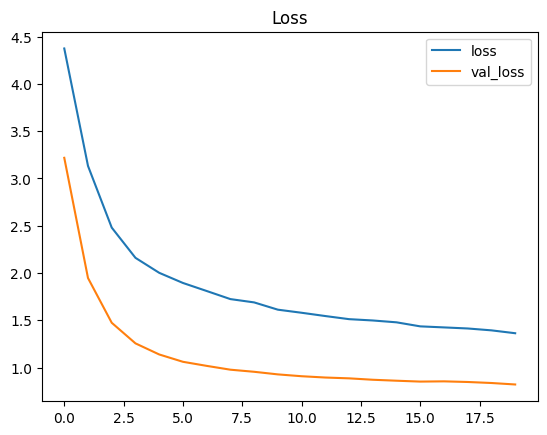

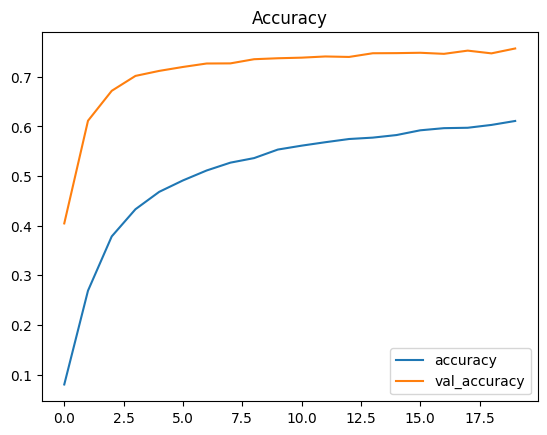

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Eğitim geçmişini DataFrame'e çevir
history_df = pd.DataFrame(history.history)

# Eğitim geçmişini yazdır
print(history_df)

# Kayıp (loss) ve doğruluk (accuracy) grafiği
history_df[['loss', 'val_loss']].plot(title='Loss')
history_df[['accuracy', 'val_accuracy']].plot(title='Accuracy')
plt.show()



In [12]:
from tensorflow.keras.models import load_model

model = load_model('trained_model.keras')
model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 49,503,978 (188.84 MB)

 Trainable params: 11,615,864 (44.31 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

 Optimizer params: 23,231,730 (88.62 MB)